In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.8/782.8 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt-get install tesseract-ocr-ind


Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,626 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 7

# Packages

In [3]:
import cv2
import numpy as np
import pytesseract
import re
import json
import matplotlib.pyplot as plt

from PIL import Image
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Import model

In [4]:
# Load a pretrained YOLOv8n model
model = YOLO("/content/best.pt")

# Deteksi Nutrition table

In [25]:
# Load an image
image_path = "/content/image8.jpg"
image = cv2.imread(image_path)


image 1/1 /content/image8.jpg: 800x608 1 nutrition_table, 21.4ms
Speed: 12.5ms preprocess, 21.4ms inference, 3.1ms postprocess per image at shape (1, 3, 800, 608)


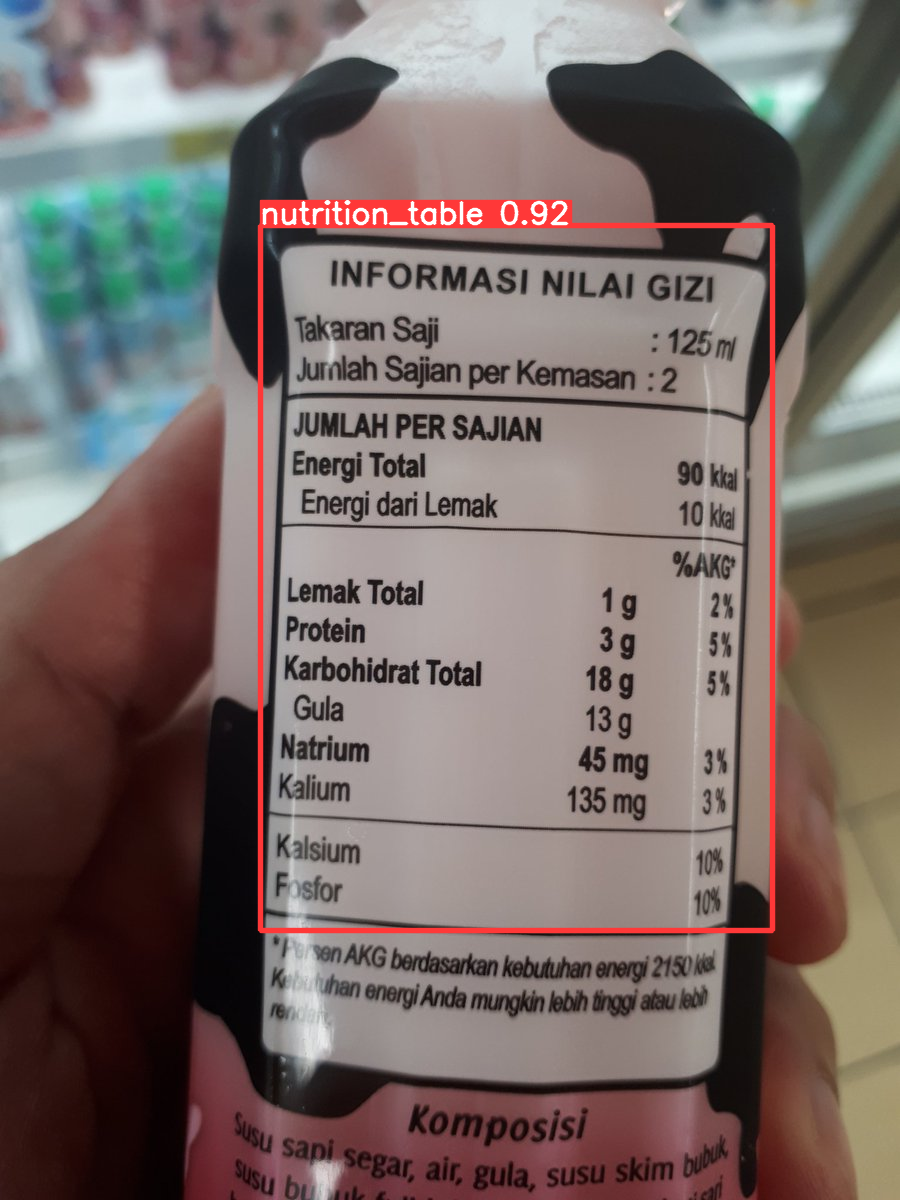

In [26]:
# Melakukan inferensi
results = model(image_path)

# Menyimpan hasil inferensi ke gambar
annotated_img = results[0].plot()  # Menyimpan gambar dengan anotasi

# Tampilkan gambar menggunakan cv2_imshow
cv2_imshow(annotated_img)

In [27]:
# results

# Cropping

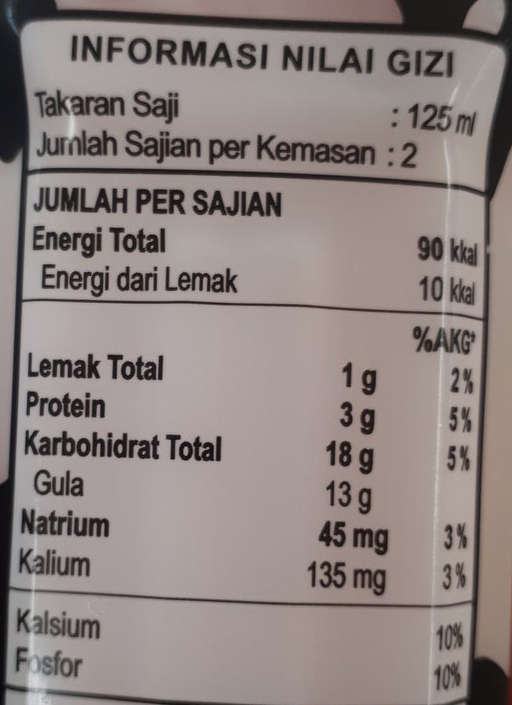

In [28]:
# Loop melalui hasil inferensi dan memotong gambar berdasarkan bounding box
for result in results:
    boxes = result.boxes  # Mendapatkan semua bounding box dari hasil inferensi
    for box in boxes:
        # Mendapatkan koordinat bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Koordinat diubah menjadi integer

        # Memotong gambar berdasarkan bounding box
        cropped_img = image[y1:y2, x1:x2]

        # Menampilkan gambar yang telah dipotong
        cv2_imshow(cropped_img)

        # Jika ingin menyimpan gambar yang telah dipotong
        cropped_img_path = f'/content/cropped_{x1}_{y1}.jpg'
        cv2.imwrite(cropped_img_path, cropped_img)

# OCR

In [29]:
def change_to_g(text):
    # Search for '9' followed by a space or at the end of the string
    search_ln = re.search(r'(\d)\s|\d$', text)
    if search_ln and search_ln.group(1) == "9":
        index = search_ln.span(1)[0]
        text = text[:index] + "g" + text[index+1:]

    # Search for 'mq' that is followed by a space or at the end of the string
    search_lnq = re.search(r'(\d)mq\s|\d$', text)
    if search_lnq:
        index = search_lnq.span()[0] + 1
        text = text[:index] + "g" + text[index+1:]

    return text

In [30]:

def clean_string(string):
    pattern = r'[\|\*\_\'\—\-\{}]'.format('"')
    text = re.sub(pattern, "", string)
    text = re.sub(" I ", " / ", text)
    text = re.sub("^I ", "", text)
    text = re.sub("%", "", text)
    text = re.sub("gy", "", text)
    text = re.sub("lg", "1g", text)
    text = re.sub("Ng", "", text)
    text = re.sub("oy", "", text)
    text = re.sub("°", "g", text)
    text = re.sub("Protein.", "Protein", text)
    text = re.sub("Sugar", "gula", text)
    text = re.sub("Omg", "0mg", text)
    text = re.sub("Og", "0g", text)
    text = re.sub(r'(?<=\d) (?=\w)', '', text)
    text = change_to_g(text)
    text = text.strip()
    return text

In [31]:
import cv2
def NutritionOCR(file_path):
    # Convert to grayscale
    gray = cv2.cvtColor(file_path, cv2.COLOR_BGR2GRAY)

    # Threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_TRUNC)

    # Apply thresholding to get a binary image
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply dilation and erosion to remove some noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    cleaned = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    # Perform OCR on the cleaned image
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(cleaned, config=custom_config)
    text = clean_string(text)
    # print(text)

    # Parsing the OCR result into a dictionary
    nutritional_info = {}
    lines = text.split('\n')
    for line in lines:
        match_lemak_total = re.search(r'lemak total.*?(\d+\.?\d*)\s*(g|gr|9)', line, re.IGNORECASE)
        match_protein = re.search(r'protein\s*(\d+\.?\d*)\s*(g|gr|9)', line, re.IGNORECASE)
        match_karbohidrat_total = re.search(r'karbohidrat total.*?(\d+\.?\d*)\s*(g|gr|9)', line, re.IGNORECASE)
        match_gula = re.search(r'gula.*?(\d+\.?\d*)\s*(g|gr|9)', line, re.IGNORECASE)

        if match_lemak_total:
            nutritional_info["Lemak Total"] = float(match_lemak_total.group(1))
        elif match_protein:
            nutritional_info["Protein"] = float(match_protein.group(1))
        elif match_karbohidrat_total:
            nutritional_info["Karbohidrat Total"] = float(match_karbohidrat_total.group(1))
        elif match_gula:
            nutritional_info["Gula"] = float(match_gula.group(1))

    return nutritional_info

In [32]:
# Path to the image file
filePath = cropped_img

# Call the NutritionOCR function
nutrition_info = NutritionOCR(filePath)

# Print the result in JSON format
print(json.dumps(nutrition_info, indent=2))

{
  "Lemak Total": 1.0,
  "Protein": 3.0,
  "Karbohidrat Total": 18.0,
  "Gula": 13.0
}
